<a href="https://colab.research.google.com/github/vadim-privalov/-/blob/main/%D0%91%D0%BE%D0%BB%D1%8C%D1%88%D0%BE%D0%B5_%D0%94%D0%97_2_%D0%BA%D0%BE%D0%BF%D0%B8%D1%8F__ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 style="text-align: center;"><b>Большое домашнее задание 2. Участие в соревнованиях на Kaggle. Работа с нерепрезентативными данными.
</b></h2>

ДЗ в колабе: https://colab.research.google.com/drive/18Hi97eESCrXYht-7SIoj_19pwcZhl17Y?usp=sharing

В этом домашнем задании нам нужно применить в реальном соревновании накопленные знания по машинному обучению и анализу данных!

- Нужно будет провести предобработку [данных с Kaggle](https://www.kaggle.com/sid321axn/thoraric-surgery). Затем нужно будет предсказать колонку DGN (диагноз). Это задача классификации. 
- Описание датасета (что значит признаки): https://archive.ics.uci.edu/ml/datasets/Thoracic+Surgery+Data 
- Не забудьте провести анализ данных перед тем, как применять ML-модели! Вам нужно сначала понять, с чем Вы имеете дело, поискать зависимости в данных, понять природу этих зависимостей, и только после этого уже подбирать алгоритмы. Данные с подвохом! Внимательно смотрите на распределения признаков в каждом из классов!
- В качестве основы можно использовать наработки с занятий. Необходимо попробовать сделать аугментацию данных, т.к. данных очень мало, для обучения содержательных моделей их не хватит.
- Попробуйте kNN, логистическую регрессию, SVM. Поэкспериментируйте с добавлением композитных признаков (например, полиномиальных), выбором ядра (для SVM). Подберите гиперпараметры по кросс-валидации (GridSearchCV или RandomSearchCV, второй вариант предпочтительнее).  
- Достичь идеального качества Вам не удастся, да и гнаться за этим не стоит. Гораздо важнее провести вдумчивый анализ и показать, что Вы разобрались в теме.

**Правила:**

- **Дедлайн один:** 29 января 23:59. Решения, отправленные позже, проверяться не будут, кроме случаев наличия уважительной причины.



Решения, размещенные на каких-либо интернет-ресурсах, не принимаются.
 При написании кода придерживайтесь `pep8` и используйте `type hints`.

**После жесткого дедлайна задания не принимаются. Так как дальше будет работа только над проектом**

In [1]:
# Загружаем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
pd.options.display.max_rows = 10
from imblearn.under_sampling import TomekLinks
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from random import sample
import warnings
from imblearn.over_sampling import SMOTE, ADASYN
warnings.filterwarnings("ignore")

In [2]:
pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.7.0)


In [3]:
# Загружаем датасет с Гитхаб и отобразим его
df = pd.read_csv('https://raw.githubusercontent.com/vadim-privalov/-/main/ThoraricSurgery.csv',
                 sep = ',', index_col = 'id')
df

,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr
id,,,,,,,,,,,,,,,,,
1,DGN2,2.88,2.16,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,60,F
2,DGN3,3.40,1.88,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,51,F
3,DGN3,2.76,2.08,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,59,F
4,DGN3,3.68,3.04,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,54,F
5,DGN3,2.44,0.96,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,73,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,DGN2,3.88,2.12,PRZ1,F,F,F,T,F,OC13,F,F,F,T,F,63,F
467,DGN3,3.76,3.12,PRZ0,F,F,F,F,F,OC11,F,F,F,T,F,61,F
468,DGN3,3.04,2.08,PRZ1,F,F,F,T,F,OC13,F,F,F,F,F,52,F


In [4]:
df.describe() # отображаем статистику по столбцам с цисловыми значениями

,PRE4,PRE5,AGE
count,470.000000,470.000000,470.000000
mean,3.281638,4.568702,62.534043
std,0.871395,11.767857,8.706902
min,1.440000,0.960000,21.000000
25%,2.600000,1.960000,57.000000
50%,3.160000,2.400000,62.000000
75%,3.807500,3.080000,69.000000
max,6.300000,86.300000,87.000000


Из полученных данных видим, что возраст пациентов не выбивается запредельно (младенцы и столетние), а так же значения PRE 4 и 5 не имеют непонятного разброса


In [5]:
# Переменуем столбцы с данными для понимания входных данных и дальнейшего удобства в работе
df.rename(columns = {'DGN': 'диагноз', 'PRE4': 'легкие', 'PRE5': 'производительность', 'PRE6': 'состояние', 'PRE7': 'боль',
          'PRE8': 'кровохаркание', 'PRE9': 'одышка', 'PRE10': 'кашель', 'PRE11': 'слабость', 'PRE14': 'размер', 'PRE17': 'диабет',
          'PRE19': 'им', 'PRE25': 'артерии', 'PRE30': 'курение', 'PRE32': 'астма', 'AGE': 'возраст', 'Risk1Yr': 'смертность'},
            inplace=True)
df

,диагноз,легкие,производительность,состояние,боль,кровохаркание,одышка,кашель,слабость,размер,диабет,им,артерии,курение,астма,возраст,смертность
id,,,,,,,,,,,,,,,,,
1,DGN2,2.88,2.16,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,60,F
2,DGN3,3.40,1.88,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,51,F
3,DGN3,2.76,2.08,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,59,F
4,DGN3,3.68,3.04,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,54,F
5,DGN3,2.44,0.96,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,73,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,DGN2,3.88,2.12,PRZ1,F,F,F,T,F,OC13,F,F,F,T,F,63,F
467,DGN3,3.76,3.12,PRZ0,F,F,F,F,F,OC11,F,F,F,T,F,61,F
468,DGN3,3.04,2.08,PRZ1,F,F,F,T,F,OC13,F,F,F,F,F,52,F


In [6]:
# Зная общее количество строк, проверяем наш df на наличие NaN по каждому столбцу
df.count(axis=0) 

диагноз               470
легкие                470
производительность    470
состояние             470
боль                  470
                     ... 
артерии               470
курение               470
астма                 470
возраст               470
смертность            470
Length: 17, dtype: int64

In [7]:
# определяем типы данных по столбцам
df.dtypes 

диагноз                object
легкие                float64
производительность    float64
состояние              object
боль                   object
                       ...   
артерии                object
курение                object
астма                  object
возраст                 int64
смертность             object
Length: 17, dtype: object

Как видно из ответа, у нас есть столбцы с "обьектами", которые необходимо перевести в цифровые данные. Для этого перемешиваем df для дальнейшей работы с моделями обучения) и вызываем класс предобработки данных

In [8]:
# перемешка
df = df.sample(frac=1).reset_index(drop=True)


In [9]:
# Подключаем класс для предобработки данных
from sklearn import preprocessing

# Напишем функцию, которая принимает на вход DataFrame, кодирует числовыми значениями категориальные признаки
# и возвращает обновленный DataFrame и сами кодировщики.
def number_encode_features(init_df):
    result = init_df.copy() 
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object: # np.object -- строковый тип / если тип столбца - строка, то нужно его закодировать
            encoders[column] = preprocessing.LabelEncoder() # для колонки column создаем кодировщик
            result[column] = encoders[column].fit_transform(result[column]) # применяем кодировщик к столбцу и перезаписываем столбец
    return result, encoders

encoded_data, encoders = number_encode_features(df) 
encoded_data.head()

,диагноз,легкие,производительность,состояние,боль,кровохаркание,одышка,кашель,слабость,размер,диабет,им,артерии,курение,астма,возраст,смертность
0,2,3.04,2.16,1,0,0,0,1,0,1,0,0,0,0,0,78,0
1,1,3.40,2.76,1,0,1,0,1,0,1,0,0,0,1,0,56,0
2,2,1.46,1.00,1,0,1,0,1,0,0,0,0,0,1,0,68,0
3,1,2.58,1.64,2,0,1,0,1,1,1,0,0,0,1,0,63,0
4,2,2.88,2.48,0,0,0,0,0,0,0,0,0,0,1,0,71,0


In [10]:
# опять смотрим данные по столбцам, что бы удостовериться в произошедшей предобработке и исключения ошибки в ходе дальнейшей работы
encoded_data.dtypes

диагноз                 int64
легкие                float64
производительность    float64
состояние               int64
боль                    int64
                       ...   
артерии                 int64
курение                 int64
астма                   int64
возраст                 int64
смертность              int64
Length: 17, dtype: object

2    349
1     52
3     47
4     15
5      4
6      2
0      1
Name: диагноз, dtype: int64


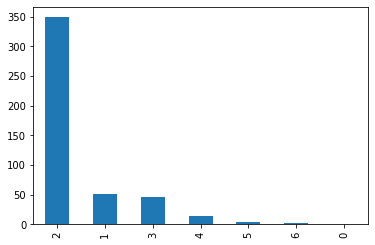

In [11]:
# т.к. мы решаем задачу классификации и предсказываем Диагноз, то определяем 
# количество уникальных значений по классам в столбце Диагноз и отображаем данные графически
s = encoded_data['диагноз'].value_counts()
s1 = sum(encoded_data["диагноз"]) / len(encoded_data["диагноз"])
print(s)
s.plot(kind='bar')
plt.show()

Количество наших данныех по наблюдениям и определения диагноза имеют сильный разброс, поэтому надо либо удалять миннимальные наблюдения (но данных и так мало) либо обьединить какие то диагнозы, а то модель будет обучаться только по диагнозу 2 

In [12]:
# обьединим дагнозы 0, 5, 6 и 4, обозначив их как диагноз 4
encoded_data['диагноз'] = np.where(encoded_data['диагноз'].isin([0, 5, 6]), 4, encoded_data['диагноз'])
encoded_data.head()

,диагноз,легкие,производительность,состояние,боль,кровохаркание,одышка,кашель,слабость,размер,диабет,им,артерии,курение,астма,возраст,смертность
0,2,3.04,2.16,1,0,0,0,1,0,1,0,0,0,0,0,78,0
1,1,3.40,2.76,1,0,1,0,1,0,1,0,0,0,1,0,56,0
2,2,1.46,1.00,1,0,1,0,1,0,0,0,0,0,1,0,68,0
3,1,2.58,1.64,2,0,1,0,1,1,1,0,0,0,1,0,63,0
4,2,2.88,2.48,0,0,0,0,0,0,0,0,0,0,1,0,71,0


2    349
1     52
3     47
4     22
Name: диагноз, dtype: int64


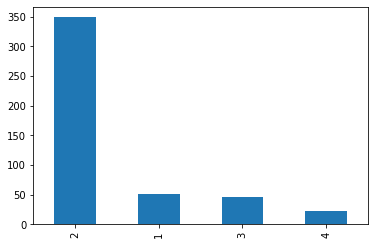

In [13]:
# смотрим, что получилось после обьединения
s = encoded_data['диагноз'].value_counts()
s1 = sum(encoded_data["диагноз"]) / len(encoded_data["диагноз"])
print(s)
s.plot(kind='bar')
plt.show()

Получились не такие огромные (в сотни раз) разбросы по наблюдениям

In [14]:
# выделяем целевую переменную и удаляем ее из нашего df
y = np.array(encoded_data['диагноз'])
del encoded_data['диагноз']
encoded_data

,легкие,производительность,состояние,боль,кровохаркание,одышка,кашель,слабость,размер,диабет,им,артерии,курение,астма,возраст,смертность
0,3.04,2.16,1,0,0,0,1,0,1,0,0,0,0,0,78,0
1,3.40,2.76,1,0,1,0,1,0,1,0,0,0,1,0,56,0
2,1.46,1.00,1,0,1,0,1,0,0,0,0,0,1,0,68,0
3,2.58,1.64,2,0,1,0,1,1,1,0,0,0,1,0,63,0
4,2.88,2.48,0,0,0,0,0,0,0,0,0,0,1,0,71,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,2.88,2.16,0,0,0,0,0,0,1,0,0,0,1,0,59,0
466,3.04,2.04,1,0,0,0,1,0,1,0,0,0,1,0,67,0
467,2.96,1.88,1,0,0,0,1,1,3,0,0,0,1,0,60,0
468,4.56,72.80,0,1,1,0,1,0,1,0,0,0,1,0,57,0


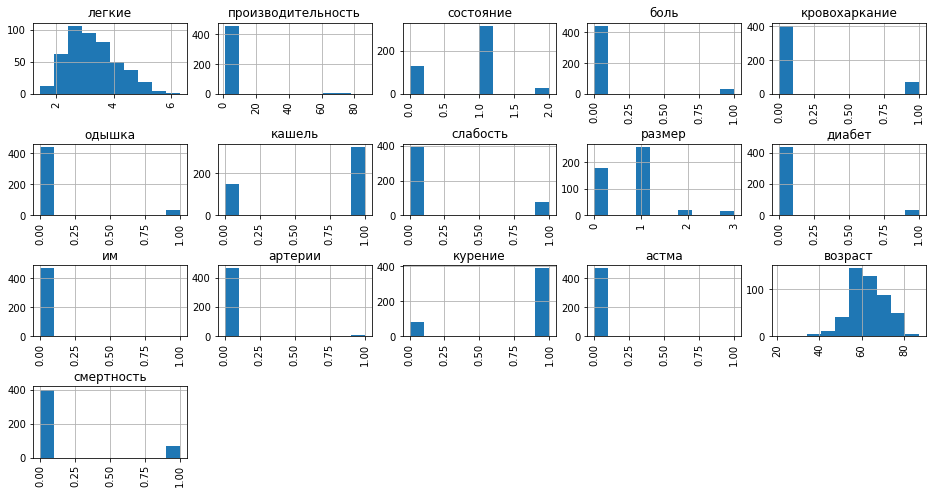

In [15]:
# смотрим на балансировку наших данных по столбцам
fig = plt.figure(figsize=(16,8))
cols = 5

rows = np.ceil(float(encoded_data.shape[1]) / cols)
for i, column in enumerate(encoded_data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    encoded_data[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

Данные не сбалансированы, столбцы "размер, возраст"

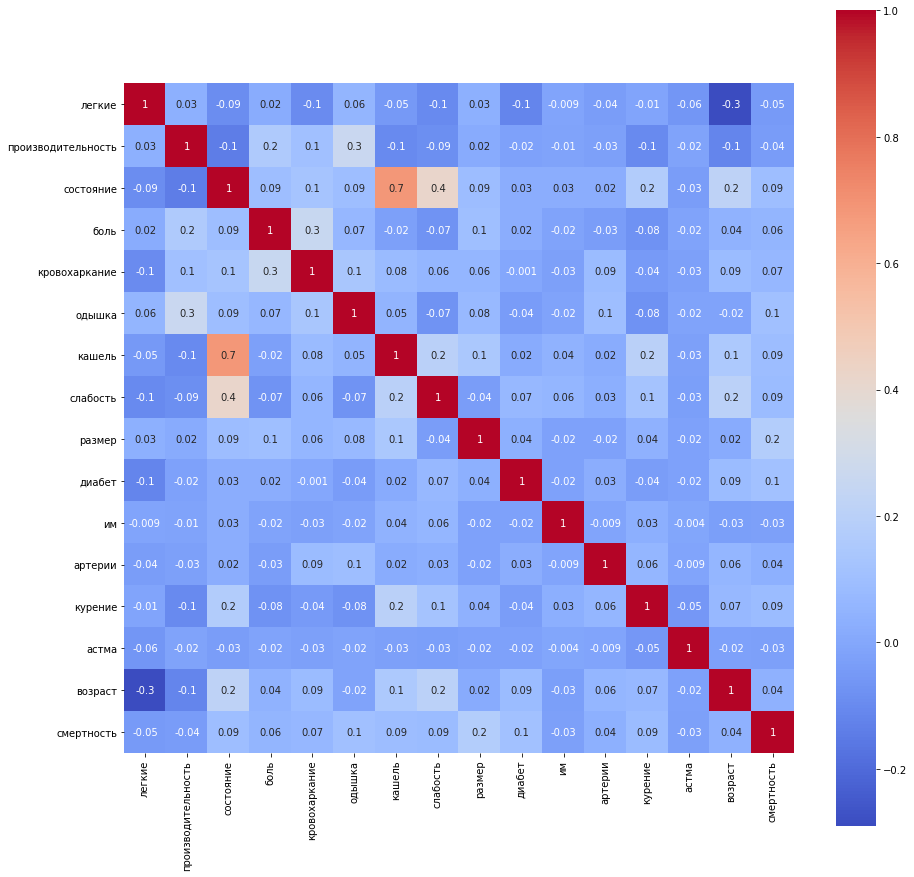

In [16]:
# проверяем наши данные на зависимость друг от друга
plt.subplots(figsize=(15,15))
encoded_data, encoders = number_encode_features(encoded_data)
sns.heatmap(encoded_data.corr(), annot = True, fmt='.1g', square=True, cmap= 'coolwarm')
plt.show()

Единичной связанности нет, но зависимость состояние - кашель и слабость явно выбиваются из общего распределения. Для чистоты предсказывания диагноза можно удалить данные по состоянию

In [17]:
encoded_data = encoded_data.drop(['состояние' ], axis = 1)

In [18]:
# Передаем наши данные в массив-матрицу и масштабируем данные
from sklearn.preprocessing import scale
X = np.array(encoded_data[encoded_data._get_numeric_data().columns])

X_scaled = scale(np.array(X, dtype='float'), with_std=True, with_mean=True)
X_scaled

array([[-0.277596  , -0.20490295, -0.26573489, ..., -0.06537205,
         1.7781798 , -0.41833001],
       [ 0.13597486, -0.15386228, -0.26573489, ..., -0.06537205,
        -0.75124366, -0.41833001],
       [-2.09271255, -0.30358158, -0.26573489, ..., -0.06537205,
         0.62844186, -0.41833001],
       ...,
       [-0.36950063, -0.22872193, -0.26573489, ..., -0.06537205,
        -0.29134848, -0.41833001],
       [ 1.46859208,  5.80428533,  3.76314899, ..., -0.06537205,
        -0.63626986, -0.41833001],
       [ 0.59549804, -0.07559992, -0.26573489, ..., -0.06537205,
         0.0535729 , -0.41833001]])

In [19]:
# Проверим целевую переменную на наличие значения 0
not_churn_ids = np.argwhere(y == 0).flatten()
print('Всего не ушедших', len(not_churn_ids))
not_churn_ids

Всего не ушедших 0


array([], dtype=int64)

Т.к. значений 0 у нас нет, то и удалять никакие строки не будем

In [20]:
# для простоты работы перепресвоим массив Х и отобразим итоговые размеры признаков
X = X_scaled
X.shape, y.shape

((470, 15), (470,))

In [21]:
# Разделим наш массив на тестовую часть и обучаемую
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

Не добавляя ни каких новых признаков попробуем обучить нашу модель

In [22]:
np.array(np.linspace(1, 100, 10), dtype='int')

array([  1,  12,  23,  34,  45,  56,  67,  78,  89, 100])

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

grid = {'n_neighbors': np.array(np.linspace(1, 100), dtype='int')} 

# Создаем объект кросс-валидации
gs = GridSearchCV(knn, grid, cv=10)

# Обучаем его
gs.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([  1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,  25,
        27,  29,  31,  33,  35,  37,  39,  41,  43,  45,  47,  49,  51,
        53,  55,  57,  59,  61,  63,  65,  67,  69,  71,  73,  75,  77,
        79,  81,  83,  85,  87,  89,  91,  93,  95,  97, 100])})

In [24]:
# Функция отрисовки графиков
def grid_plot(x, y, x_label, title, y_label='knn'):
    plt.figure(figsize=(12, 6))
    plt.grid(True)
    plt.plot(x, y, 'go-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

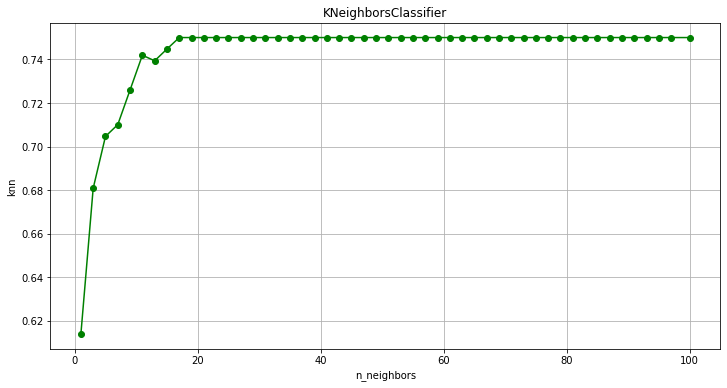

In [25]:
grid_plot(grid['n_neighbors'], gs.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

In [26]:
gs.best_params_, gs.best_score_

({'n_neighbors': 17}, 0.7500711237553344)

In [27]:
knn = KNeighborsClassifier(n_neighbors=7) 
# тренируем knn
clf_knn = knn.fit(X_train, y_train)
# вычисляем прогноз
y_knn = clf_knn.predict(X_test)

In [28]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_knn))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         7
           2       0.72      0.99      0.83        67
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00         9

    accuracy                           0.70        94
   macro avg       0.18      0.25      0.21        94
weighted avg       0.51      0.70      0.59        94



Т.к. данных для корректного обучения очень мало, данные нерепрезентативны, то  введем полиномные признаки и проведем аугументацию (путем добавления данных в меньшие классы)


In [29]:
from sklearn.preprocessing import PolynomialFeatures
def create_polinomial(X, degree = 2):
    return PolynomialFeatures(degree).fit_transform(X)
X_train = create_polinomial(X_train, 2)
X_test = create_polinomial(X_test, 2)
X_train.shape, X_test.shape    

((376, 136), (94, 136))

In [30]:
def oversample_data(X, y):
    return ADASYN(sampling_strategy='minority').fit_resample(np.array(X), np.array(y))
def augment_data(X, y):
    try:
        X, y = oversample_data(X, y)
    except:
        pass
    return X, y
X_train, y_train = augment_data(X_train, y_train)
X_train.shape, y_train.shape


((641, 136), (641,))

Данных стало больше, попробуем еще раз обучить наши модели

In [31]:
np.array(np.linspace(1, 100, 10), dtype='int')

array([  1,  12,  23,  34,  45,  56,  67,  78,  89, 100])

In [32]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
# Зададим сетку - среди каких значений выбирать наилучший параметр.
grid = {'n_neighbors': np.array(np.linspace(1, 100), dtype='int')} 

# Создаем объект кросс-валидации
gs = GridSearchCV(knn, grid, cv=10)

# Обучаем его
gs.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([  1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,  25,
        27,  29,  31,  33,  35,  37,  39,  41,  43,  45,  47,  49,  51,
        53,  55,  57,  59,  61,  63,  65,  67,  69,  71,  73,  75,  77,
        79,  81,  83,  85,  87,  89,  91,  93,  95,  97, 100])})

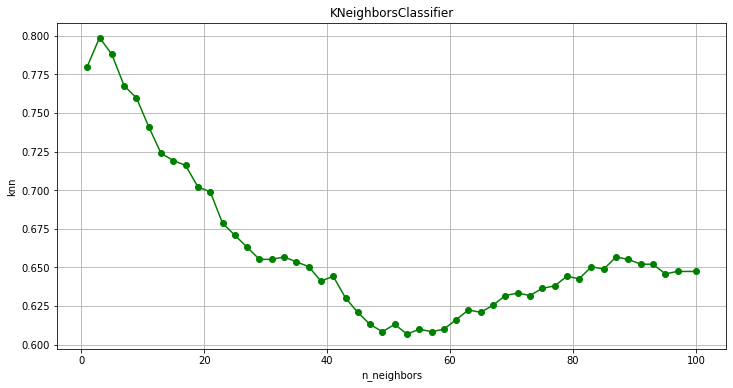

In [33]:
grid_plot(grid['n_neighbors'], gs.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

In [34]:
gs.best_params_, gs.best_score_

({'n_neighbors': 3}, 0.79875)

In [35]:
knn = KNeighborsClassifier(n_neighbors=7) 
# тренируем knn
clf_knn = knn.fit(X_train, y_train)
# вычисляем прогноз
y_knn = clf_knn.predict(X_test)
# возвращаем метрики
print(metrics.classification_report(y_test, y_knn))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         7
           2       0.74      0.87      0.80        67
           3       0.00      0.00      0.00        11
           4       0.08      0.11      0.09         9

    accuracy                           0.63        94
   macro avg       0.21      0.24      0.22        94
weighted avg       0.54      0.63      0.58        94



После введения дополнительных искуственных данных, модель стала предсказывать и другие диагнозы

In [36]:
# метод опорных векторов
from sklearn.svm import SVC

In [37]:
# вычисляем лучший коэффициент C и "ядра"
alg = SVC()

grid = {'C': np.array(np.linspace(0.001, 10), dtype='float'), # коэффициент С
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], # ядра
        }

gs = GridSearchCV(alg, grid, verbose=2, n_jobs = -1, scoring = 'f1')
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


({'C': 0.001, 'kernel': 'linear'}, nan)

In [38]:
alg = SVC(C =  0.001, kernel = 'linear')
alg.fit(X_train, y_train)
preds = alg.predict(X_test)
print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         7
           2       0.76      0.84      0.79        67
           3       0.00      0.00      0.00        11
           4       0.10      0.22      0.14         9

    accuracy                           0.62        94
   macro avg       0.21      0.26      0.23        94
weighted avg       0.55      0.62      0.58        94



Модель чуть подтянула Диагноз 4, но ухудшила Диагноз 2

In [39]:
# логистическая, используем GridSearch для автоматического подбора параметров
alg = LogisticRegression(class_weight = 'balanced')

grid = {'penalty': ['l1', 'l2', 'elasticnet'],
        'C': np.array(np.logspace(-3, 2, num = 10), dtype='float')}

gs = GridSearchCV(alg, grid, verbose=2, n_jobs = -1)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


({'C': 100.0, 'penalty': 'l2'}, 0.6695009689922481)

In [40]:
logreg = LogisticRegression(penalty='l2', C = 100.0)

logreg.fit(X_train, y_train)

preds = logreg.predict(X_test)

print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.12      0.14      0.13         7
           2       0.77      0.85      0.81        67
           3       0.17      0.09      0.12        11
           4       0.17      0.11      0.13         9

    accuracy                           0.64        94
   macro avg       0.31      0.30      0.30        94
weighted avg       0.59      0.64      0.61        94



Логистическая регрессия показала себя лучше других и пусть плохо, но обучилась по всем 4 диагнозам

Для логистической регресси попробуем улучшить производительность с подходами OneVSRest / OneVSOne и сравнить с нашим предыдушим обучением

In [41]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from numpy import mean

In [42]:
names = ["Logistic"]


classifiers = [LogisticRegression(random_state = 2, solver = 'lbfgs', max_iter = 5000, multi_class = 'auto')]

def train_clfs(classifiers, X, y):
    scoring = 'balanced_accuracy'
    
    scores_multi_val, scores_ovr_val, scores_ovo_val = [], [], []
    
    for model in classifiers:
        
        score = mean(cross_val_score(model, X, y, cv=5, scoring = scoring))
        scores_multi_val.append(score)
        
        score = mean(cross_val_score(OneVsRestClassifier(model), X, y, cv=5, scoring = scoring))
        scores_ovr_val.append(score)
        
        score = mean(cross_val_score(OneVsOneClassifier(model), X, y, cv=5, scoring = scoring))
        scores_ovo_val.append(score)
        
    scores_val = [scores_multi_val, scores_ovr_val, scores_ovo_val]
        
    return scores_val


#Обучение модели
scores_val = train_clfs(classifiers, X, y)


#display results
from IPython.display import display, HTML

print("Cross Validation Scores")
df_val = pd.DataFrame(scores_val, 
               columns =['LogReg']) 
df_val = df_val.set_index([pd.Index(['Multiclass', 'OneVsRest', 'OneVsOne'])])
display(df_val)



Cross Validation Scores


,LogReg
Multiclass,0.252847
OneVsRest,0.255000
OneVsOne,0.248561


Из-за малого количесва данных, результаты не сильно разняться и все показали очень маленький результат, но тем не менее в нашем случае OneVsRest повел себя лучше других